In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from scipy.stats import ranksums
from bayes_opt import BayesianOptimization

In [2]:
def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

In [3]:
def one_hot_encoder(data, nan_as_category = True):
    original_columns = list(data.columns)
    categorical_columns = [col for col in data.columns \
                           if not pd.api.types.is_numeric_dtype(data[col].dtype)]
    for c in categorical_columns:
        if nan_as_category:
            data[c].fillna('NaN', inplace = True)
        values = list(data[c].unique())
        for v in values:
            data[str(c) + '_' + str(v)] = (data[c] == v).astype(np.uint8)
    data.drop(categorical_columns, axis = 1, inplace = True)
    return data, [c for c in data.columns if c not in original_columns]

In [4]:
file_path = 'C:/Users/tiger/Desktop/Home Credit Default Risk/'

In [5]:
def application_train_test(file_path = file_path, nan_as_category = True):
    # Read data and merge
    df_train = pd.read_csv(file_path + 'application_train.csv')
    df_test = pd.read_csv(file_path + 'application_test.csv')
    df = pd.concat([df_train, df_test], axis = 0, ignore_index = True)
    del df_train, df_test
    gc.collect()
    
    # Remove some rows with values not present in test set
    df.drop(df[df['CODE_GENDER'] == 'XNA'].index, inplace = True)
    df.drop(df[df['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
    df.drop(df[df['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)
    
    # Remove some empty features
    df.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)
    
    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    
    # Replace some outliers
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    df.loc[df['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
    df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
    df.loc[df['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
    df.loc[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, _ = one_hot_encoder(df, nan_as_category)
    
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Time ratios
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    
    # Some new features
    df['app missing'] = df.isnull().sum(axis = 1).values
    
    df['app EXT_SOURCE mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    df['app EXT_SOURCE std'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    df['app EXT_SOURCE prod'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['app EXT_SOURCE_1 * EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_2 / DAYS_BIRTH'] = df['EXT_SOURCE_2'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_3 / DAYS_BIRTH'] = df['EXT_SOURCE_3'] / df['DAYS_BIRTH']
    
    df['app AMT_CREDIT - AMT_GOODS_PRICE'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_ANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['app AMT_CREDIT / AMT_INCOME_TOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
    df['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    
    df['app most popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] \
                        .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
    df['app popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] \
                        .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
    
    df['app OWN_CAR_AGE / DAYS_BIRTH'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['app OWN_CAR_AGE / DAYS_EMPLOYED'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['app DAYS_EMPLOYED - DAYS_BIRTH'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']
    df['app DAYS_EMPLOYED / DAYS_BIRTH'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    df['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
    
    return reduce_mem_usage(df)

In [6]:
def bureau_and_balance(file_path = file_path, nan_as_category = True):
    df_bureau_b = reduce_mem_usage(pd.read_csv(file_path + 'bureau_balance.csv'), verbose = False)
    
    
    # Some new features in bureau_balance set
    tmp = df_bureau_b[['SK_ID_BUREAU', 'STATUS']].groupby('SK_ID_BUREAU')
    tmp_last = tmp.last()
    tmp_last.columns = ['First_status']
    df_bureau_b = df_bureau_b.join(tmp_last, how = 'left', on = 'SK_ID_BUREAU')
    tmp_first = tmp.first()
    tmp_first.columns = ['Last_status']
    df_bureau_b = df_bureau_b.join(tmp_first, how = 'left', on = 'SK_ID_BUREAU')
    del tmp, tmp_first, tmp_last
    gc.collect()
    
    tmp = df_bureau_b[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').last()
    tmp = tmp.apply(abs)
    tmp.columns = ['Month']
    df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
    del tmp
    gc.collect()
    
    tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == 'C', ['SK_ID_BUREAU', 'MONTHS_BALANCE']] \
                .groupby('SK_ID_BUREAU').last()
    tmp = tmp.apply(abs)
    tmp.columns = ['When_closed']
    df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
    del tmp
    gc.collect()
    
    df_bureau_b['Month_closed_to_end'] = df_bureau_b['Month'] - df_bureau_b['When_closed']

    for c in range(6):
        tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == str(c), ['SK_ID_BUREAU', 'MONTHS_BALANCE']] \
                         .groupby('SK_ID_BUREAU').count()
        tmp.columns = ['DPD_' + str(c) + '_cnt']
        df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
        df_bureau_b['DPD_' + str(c) + ' / Month'] = df_bureau_b['DPD_' + str(c) + '_cnt'] / df_bureau_b['Month']
        del tmp
        gc.collect()
    df_bureau_b['Non_zero_DPD_cnt'] = df_bureau_b[['DPD_1_cnt', 'DPD_2_cnt', 'DPD_3_cnt', 'DPD_4_cnt', 'DPD_5_cnt']].sum(axis = 1)
    
    df_bureau_b, bureau_b_cat = one_hot_encoder(df_bureau_b, nan_as_category)

    # Bureau balance: Perform aggregations 
    aggregations = {}
    for col in df_bureau_b.columns:
        aggregations[col] = ['mean'] if col in bureau_b_cat else ['min', 'max', 'size']
    df_bureau_b_agg = df_bureau_b.groupby('SK_ID_BUREAU').agg(aggregations)
    df_bureau_b_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_bureau_b_agg.columns.tolist()])
    del df_bureau_b
    gc.collect()

    df_bureau = reduce_mem_usage(pd.read_csv(file_path + 'bureau.csv'), verbose = False)
    
    # feature engineering
    # Credit duration and credit/account end date difference
    df_bureau['CREDIT_DURATION'] = -df_bureau['DAYS_CREDIT'] + df_bureau['DAYS_CREDIT_ENDDATE']
    df_bureau['ENDDATE_DIF'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    df_bureau['DEBT_PERCENTAGE'] = df_bureau['AMT_CREDIT_SUM'] / df_bureau['AMT_CREDIT_SUM_DEBT']
    df_bureau['DEBT_CREDIT_DIFF'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_DEBT']
    df_bureau['CREDIT_TO_ANNUITY_RATIO'] = df_bureau['AMT_CREDIT_SUM'] / df_bureau['AMT_ANNUITY']

    # Replace\remove some outliers in bureau set
    df_bureau.loc[df_bureau['AMT_ANNUITY'] > .8e8, 'AMT_ANNUITY'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_SUM'] > 3e8, 'AMT_CREDIT_SUM'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_SUM_DEBT'] > 1e8, 'AMT_CREDIT_SUM_DEBT'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_MAX_OVERDUE'] > .8e8, 'AMT_CREDIT_MAX_OVERDUE'] = np.nan
    df_bureau.loc[df_bureau['DAYS_ENDDATE_FACT'] < -10000, 'DAYS_ENDDATE_FACT'] = np.nan
    df_bureau.loc[(df_bureau['DAYS_CREDIT_UPDATE'] > 0) | (df_bureau['DAYS_CREDIT_UPDATE'] < -40000), 'DAYS_CREDIT_UPDATE'] = np.nan
    df_bureau.loc[df_bureau['DAYS_CREDIT_ENDDATE'] < -10000, 'DAYS_CREDIT_ENDDATE'] = np.nan
    
    df_bureau.drop(df_bureau[df_bureau['DAYS_ENDDATE_FACT'] < df_bureau['DAYS_CREDIT']].index, inplace = True)
    
    # Some new features in bureau set
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_DEBT']
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_LIMIT']
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_OVERDUE']

    df_bureau['bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE'] = df_bureau['DAYS_CREDIT'] - df_bureau['CREDIT_DAY_OVERDUE']
    df_bureau['bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_CREDIT_ENDDATE']
    df_bureau['bureau DAYS_CREDIT - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT_UPDATE'] - df_bureau['DAYS_CREDIT_ENDDATE']
    
    # Categorical features with One-Hot encode
    df_bureau, bureau_cat = one_hot_encoder(df_bureau, nan_as_category)
    
    # Bureau balance: merge with bureau.csv
    df_bureau = df_bureau.join(df_bureau_b_agg, how = 'left', on = 'SK_ID_BUREAU')
    df_bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True)
    del df_bureau_b_agg
    gc.collect()
    
    # Bureau and bureau_balance aggregations for application set
    categorical = bureau_cat + bureau_b_cat
    aggregations = {}
    for col in df_bureau.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_bureau_agg = df_bureau.groupby('SK_ID_CURR').agg(aggregations)
    df_bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in df_bureau_agg.columns.tolist()])
    
    # Bureau: Active credits
    active_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(active_agg, how = 'left')
    del active_agg
    gc.collect()
    
    # Bureau: Closed credits
    closed_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Closed'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(closed_agg, how = 'left')
    del closed_agg, df_bureau
    gc.collect()
    
    return reduce_mem_usage(df_bureau_agg)

In [7]:
def previous_application(file_path = file_path, nan_as_category = True):
    df_prev = pd.read_csv(file_path + 'previous_application.csv')
    
    # Replace some outliers
    df_prev.loc[df_prev['AMT_CREDIT'] > 6000000, 'AMT_CREDIT'] = np.nan
    df_prev.loc[df_prev['SELLERPLACE_AREA'] > 3500000, 'SELLERPLACE_AREA'] = np.nan
    df_prev[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
             'DAYS_LAST_DUE', 'DAYS_TERMINATION']].replace(365243, np.nan, inplace = True)
    
    # Some new features
    df_prev['prev missing'] = df_prev.isnull().sum(axis = 1).values
    df_prev['prev AMT_APPLICATION / AMT_CREDIT'] = df_prev['AMT_APPLICATION'] / df_prev['AMT_CREDIT']
    df_prev['prev AMT_APPLICATION - AMT_CREDIT'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_CREDIT']
    df_prev['prev AMT_APPLICATION - AMT_GOODS_PRICE'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_GOODS_PRICE']
    df_prev['prev AMT_GOODS_PRICE - AMT_CREDIT'] = df_prev['AMT_GOODS_PRICE'] - df_prev['AMT_CREDIT']
    df_prev['prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE'] = df_prev['DAYS_FIRST_DRAWING'] - df_prev['DAYS_FIRST_DUE']
    df_prev['prev DAYS_TERMINATION less -500'] = (df_prev['DAYS_TERMINATION'] < -500).astype(int)
    
    # Categorical features with One-Hot encode
    df_prev, categorical = one_hot_encoder(df_prev, nan_as_category)

    # Aggregations for application set
    aggregations = {}
    for col in df_prev.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_prev_agg = df_prev.groupby('SK_ID_CURR').agg(aggregations)
    df_prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications
    approved_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(approved_agg, how = 'left')
    del approved_agg
    gc.collect()
    
    # Previous Applications: Refused Applications
    refused_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(refused_agg, how = 'left')
    del refused_agg, df_prev
    gc.collect()
    
    return reduce_mem_usage(df_prev_agg)

In [8]:
def pos_cash(file_path = file_path, nan_as_category = True):
    df_pos = pd.read_csv(file_path + 'POS_CASH_balance.csv')
    
    # Replace some outliers
    df_pos.loc[df_pos['CNT_INSTALMENT_FUTURE'] > 60, 'CNT_INSTALMENT_FUTURE'] = np.nan
    
    # Some new features
    df_pos['pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE'] = \
                    (df_pos['CNT_INSTALMENT'] > df_pos['CNT_INSTALMENT_FUTURE']).astype(int)
    
    # Categorical features with One-Hot encode
    df_pos, categorical = one_hot_encoder(df_pos, nan_as_category)
    
    # Aggregations for application set
    aggregations = {}
    for col in df_pos.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_pos_agg = df_pos.groupby('SK_ID_CURR').agg(aggregations)
    df_pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in df_pos_agg.columns.tolist()])

    # Count POS lines
    df_pos_agg['POS_COUNT'] = df_pos.groupby('SK_ID_CURR').size()
    del df_pos
    gc.collect()
    
    return reduce_mem_usage(df_pos_agg)

In [9]:
def installments_payments(file_path = file_path, nan_as_category = True):
    df_ins = pd.read_csv(file_path + 'installments_payments.csv')
    
    # Replace some outliers
    df_ins.loc[df_ins['NUM_INSTALMENT_VERSION'] > 70, 'NUM_INSTALMENT_VERSION'] = np.nan
    df_ins.loc[df_ins['DAYS_ENTRY_PAYMENT'] < -4000, 'DAYS_ENTRY_PAYMENT'] = np.nan
    
    # Some new features
    df_ins['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = df_ins['DAYS_ENTRY_PAYMENT'] - df_ins['DAYS_INSTALMENT']
    df_ins['ins NUM_INSTALMENT_NUMBER_100'] = (df_ins['NUM_INSTALMENT_NUMBER'] == 100).astype(int)
    df_ins['ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER'] = (df_ins['DAYS_INSTALMENT'] > df_ins['NUM_INSTALMENT_NUMBER'] * 50 / 3 - 11500 / 3).astype(int)
    df_ins['ins AMT_INSTALMENT - AMT_PAYMENT'] = df_ins['AMT_INSTALMENT'] - df_ins['AMT_PAYMENT']
    df_ins['ins AMT_PAYMENT / AMT_INSTALMENT'] = df_ins['AMT_PAYMENT'] / df_ins['AMT_INSTALMENT']
    
    # Categorical features with One-Hot encode
    df_ins, categorical = one_hot_encoder(df_ins, nan_as_category)

    # Aggregations for application set
    aggregations = {}
    for col in df_ins.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_ins_agg = df_ins.groupby('SK_ID_CURR').agg(aggregations)
    df_ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in df_ins_agg.columns.tolist()])
    
    # Count installments lines
    df_ins_agg['INSTAL_COUNT'] = df_ins.groupby('SK_ID_CURR').size()
    del df_ins
    gc.collect()
    
    return reduce_mem_usage(df_ins_agg)

In [10]:
def credit_card_balance(file_path = file_path, nan_as_category = True):
    df_card = pd.read_csv(file_path + 'credit_card_balance.csv')
    
    # Replace some outliers
    df_card.loc[df_card['AMT_PAYMENT_CURRENT'] > 4000000, 'AMT_PAYMENT_CURRENT'] = np.nan
    df_card.loc[df_card['AMT_CREDIT_LIMIT_ACTUAL'] > 1000000, 'AMT_CREDIT_LIMIT_ACTUAL'] = np.nan

    # Some new features
    df_card['card missing'] = df_card.isnull().sum(axis = 1).values
    df_card['card SK_DPD - MONTHS_BALANCE'] = df_card['SK_DPD'] - df_card['MONTHS_BALANCE']
    df_card['card SK_DPD_DEF - MONTHS_BALANCE'] = df_card['SK_DPD_DEF'] - df_card['MONTHS_BALANCE']
    df_card['card SK_DPD - SK_DPD_DEF'] = df_card['SK_DPD'] - df_card['SK_DPD_DEF']
    
    df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECIVABLE']
    df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
    df_card['card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_RECIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']

    df_card['card AMT_BALANCE - AMT_RECIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_RECIVABLE']
    df_card['card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_BALANCE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
    df_card['card AMT_BALANCE - AMT_TOTAL_RECEIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_TOTAL_RECEIVABLE']

    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_ATM_CURRENT']
    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_OTHER_CURRENT']
    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_POS_CURRENT']
    
    # Categorical features with One-Hot encode
    df_card, categorical = one_hot_encoder(df_card, nan_as_category)
    
    # Aggregations for application set
    aggregations = {}
    for col in df_card.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_card_agg = df_card.groupby('SK_ID_CURR').agg(aggregations)
    df_card_agg.columns = pd.Index(['CARD_' + e[0] + "_" + e[1].upper() for e in df_card_agg.columns.tolist()])

    # Count credit card lines
    df_card_agg['CARD_COUNT'] = df_card.groupby('SK_ID_CURR').size()
    del df_card
    gc.collect()
    
    return reduce_mem_usage(df_card_agg)

In [11]:
def aggregate(file_path = file_path):
    warnings.simplefilter(action = 'ignore')
    
    print('-' * 20)
    print('1: application train & test (', time.ctime(), ')')
    print('-' * 20)
    df = application_train_test(file_path)
    print('     DF shape:', df.shape)
    
    print('-' * 20)
    print('2: bureau & balance (', time.ctime(), ')')
    print('-' * 20)
    bureau = bureau_and_balance(file_path)
    df = df.join(bureau, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del bureau
    gc.collect()
    
    print('-' * 20)
    print('3: previous_application (', time.ctime(), ')')
    print('-' * 20)
    prev = previous_application(file_path)
    df = df.join(prev, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del prev
    gc.collect()
    
    print('-' * 20)
    print('4: POS_CASH_balance (', time.ctime(), ')')
    print('-' * 20)
    pos = pos_cash(file_path)
    df = df.join(pos, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del pos
    gc.collect()
    
    print('-' * 20)
    print('5: installments_payments (', time.ctime(), ')')
    print('-' * 20)
    ins = installments_payments(file_path)
    df = df.join(ins, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del ins
    gc.collect()
    
    print('-' * 20)
    print('6: credit_card_balance (', time.ctime(), ')')
    print('-' * 20)
    cc = credit_card_balance(file_path)
    df = df.join(cc, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del cc
    gc.collect()
    
    print('-' * 20)
    print('7: final dataset (', time.ctime(), ')')
    print('-' * 20)
    return reduce_mem_usage(df)

In [12]:
def corr_feature_with_target(feature, target):
    feature = feature.loc[~feature.index.duplicated(keep='first')]
    c0 = feature[target == 0].dropna()
    c1 = feature[target == 1].dropna()
        
    if set(feature.unique()) == set([0, 1]):
        diff = abs(c0.mean(axis = 0) - c1.mean(axis = 0))
    else:
        diff = abs(c0.median(axis = 0) - c1.median(axis = 0))
        
    p = ranksums(c0, c1)[1] if ((len(c0) >= 20) & (len(c1) >= 20)) else 2
        
    return [diff, p]

In [13]:
def clean_data(data):
    warnings.simplefilter(action = 'ignore')
    
    data = data.reset_index()
    
    # Removing empty features
    nun = data.nunique()
    empty = list(nun[nun <= 1].index)
    
    data.drop(empty, axis = 1, inplace = True)
    print('After removing empty features there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with the same distribution on 0 and 1 classes
    corr = pd.DataFrame(index = ['diff', 'p'])
    ind = data[data['TARGET'].notnull()].index
    
    for c in data.columns.drop('TARGET'):
        corr[c] = corr_feature_with_target(data.loc[ind, c], data.loc[ind, 'TARGET'])

    corr = corr.T
    corr['diff_norm'] = abs(corr['diff'] / data.mean(axis = 0))
    
    to_del_1 = corr[((corr['diff'] == 0) & (corr['p'] > .05))].index
    to_del_2 = corr[((corr['diff_norm'] < .5) & (corr['p'] > .05))].drop(to_del_1).index
    to_del = list(to_del_1) + list(to_del_2)
    if 'SK_ID_CURR' in to_del:
        to_del.remove('SK_ID_CURR')
        
    data.drop(to_del, axis = 1, inplace = True)
    print('After removing features with the same distribution on 0 and 1 classes there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with not the same distribution on train and test datasets
    corr_test = pd.DataFrame(index = ['diff', 'p'])
    target = data['TARGET'].notnull().astype(int)
    
    for c in data.columns.drop('TARGET'):
        corr_test[c] = corr_feature_with_target(data[c], target)

    corr_test = corr_test.T
    corr_test['diff_norm'] = abs(corr_test['diff'] / data.mean(axis = 0))
    
    bad_features = corr_test[((corr_test['p'] < .05) & (corr_test['diff_norm'] > 1))].index
    bad_features = corr.loc[bad_features][corr['diff_norm'] == 0].index
    
    data.drop(bad_features, axis = 1, inplace = True)
    print('After removing features with not the same distribution on train and test datasets there are {0:d} features'.format(data.shape[1]))
    
    del corr, corr_test
    gc.collect()
    
    # Removing features not interesting for classifier
    clf = LGBMClassifier(random_state = 0)
    train_index = data[data['TARGET'].notnull()].index
    train_columns = data.drop('TARGET', axis = 1).columns

    score = 1
    new_columns = []
    while score > .7:
        train_columns = train_columns.drop(new_columns)
        clf.fit(data.loc[train_index, train_columns], data.loc[train_index, 'TARGET'])
        f_imp = pd.Series(clf.feature_importances_, index = train_columns)
        score = roc_auc_score(data.loc[train_index, 'TARGET'], 
                              clf.predict_proba(data.loc[train_index, train_columns])[:, 1])
        new_columns = f_imp[f_imp > 0].index

    data.drop(train_columns, axis = 1, inplace = True)
    print('After removing features not interesting for classifier there are {0:d} features'.format(data.shape[1]))

    return data

In [50]:
def cv_scores(df, num_folds, params, stratified = False, verbose = -1, 
              save_train_prediction = False, train_prediction_file_name = 'train_prediction.csv',
              save_test_prediction = True, test_prediction_file_name = 'test_prediction.csv'):
    warnings.simplefilter('ignore')
    
    import re
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    clf = LGBMClassifier(**params)

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    else:
        folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
        
    # Create arrays and dataframes to store results
    train_pred = np.zeros(train_df.shape[0])
    train_pred_proba = np.zeros(train_df.shape[0])

    test_pred = np.zeros(train_df.shape[0])
    test_pred_proba = np.zeros(train_df.shape[0])
    
    prediction = np.zeros(test_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    df_feature_importance = pd.DataFrame(index = feats)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print('Fold', n_fold, 'started at', time.ctime())
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = verbose, early_stopping_rounds = 100)

        train_pred[train_idx] = clf.predict(train_x, num_iteration = clf.best_iteration_)
        train_pred_proba[train_idx] = clf.predict_proba(train_x, num_iteration = clf.best_iteration_)[:, 1]
        test_pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration_)
        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        prediction += \
                clf.predict_proba(test_df[feats], num_iteration = clf.best_iteration_)[:, 1] / folds.n_splits

        df_feature_importance[n_fold] = pd.Series(clf.feature_importances_, index = feats)
        
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc_score(valid_y, test_pred_proba[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    roc_auc_train = roc_auc_score(train_df['TARGET'], train_pred_proba)
    precision_train = precision_score(train_df['TARGET'], train_pred, average = None)
    recall_train = recall_score(train_df['TARGET'], train_pred, average = None)
    
    roc_auc_test = roc_auc_score(train_df['TARGET'], test_pred_proba)
    precision_test = precision_score(train_df['TARGET'], test_pred, average = None)
    recall_test = recall_score(train_df['TARGET'], test_pred, average = None)

    print('Full AUC score %.6f' % roc_auc_test)
    
    df_feature_importance.fillna(0, inplace = True)
    df_feature_importance['mean'] = df_feature_importance.mean(axis = 1)
    
    # Write prediction files
    if save_train_prediction:
        df_prediction = train_df[['SK_ID_CURR', 'TARGET']]
        df_prediction['Prediction'] = test_pred_proba
        df_prediction.to_csv(train_prediction_file_name, index = False)
        del df_prediction
        gc.collect()

    if save_test_prediction:
        df_prediction = test_df[['SK_ID_CURR']]
        df_prediction['TARGET'] = prediction
        df_prediction.to_csv(test_prediction_file_name, index = False)
        del df_prediction
        gc.collect()
    
    return df_feature_importance, \
           [roc_auc_train, roc_auc_test,
            precision_train[0], precision_test[0], precision_train[1], precision_test[1],
            recall_train[0], recall_test[0], recall_train[1], recall_test[1], 0]

In [66]:
def display_folds_importances(feature_importance_df_, n_folds = 5):
    n_columns = 3
    n_rows = (n_folds + 1) // n_columns
    _, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 8 * n_rows))
    for i in range(n_folds):
        sns.barplot(x = i, y = 'index', data = feature_importance_df_.reset_index().sort_values(i, ascending = False).head(20), 
                    ax = axes[i // n_columns, i % n_columns])
    sns.barplot(x = 'mean', y = 'index', data = feature_importance_df_.reset_index().sort_values('mean', ascending = False).head(20), 
                    ax = axes[n_rows - 1, n_columns - 1])
    plt.title('LightGBM Features importance avg')
    plt.tight_layout()
    plt.show()

In [16]:
scores_index = [
    'roc_auc_train', 'roc_auc_test', 
    'precision_train_0', 'precision_test_0', 
    'precision_train_1', 'precision_test_1', 
    'recall_train_0', 'recall_test_0', 
    'recall_train_1', 'recall_test_1', 
    'LB'
]

scores = pd.DataFrame(index = scores_index)

In [49]:
lgbm_params = {
            'boosting_type': 'goss',
            'nthread': 4,
            'n_estimators': 10000,
            'learning_rate': 0.005134,
            'num_leaves': 54,
            'colsample_bytree': .9497036,
            'subsample': .8715623,
            'max_depth': 10,
            'reg_alpha':  0.436193,
            'reg_lambda': 0.479169,
            'min_split_gain': 0.024766,
            'min_child_weight': 39.3259775,
            'verbose': -1
}

### df = aggregate()

In [25]:
df = df.loc[:,~df.columns.duplicated()]

In [24]:
df = df.reset_index()

In [26]:
df.columns.is_unique

True

In [27]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df = clean_data(df)

After removing empty features there are 3361 features
After removing features with the same distribution on 0 and 1 classes there are 2235 features
After removing features with not the same distribution on train and test datasets there are 2179 features
After removing features not interesting for classifier there are 1566 features


In [28]:
df = df.loc[:,~df.columns.duplicated()]

In [29]:
df.shape

(356244, 1566)

In [51]:
feature_importance, scor = cv_scores(df, 5, lgbm_params, test_prediction_file_name = 'prediction_0.csv')

Starting LightGBM. Train shape: (307500, 1566), test shape: (48744, 1566)
Fold 0 started at Mon Apr  5 09:23:04 2021
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3318]	training's auc: 0.899716	training's binary_logloss: 0.19132	valid_1's auc: 0.792821	valid_1's binary_logloss: 0.232764
Fold  0 AUC : 0.792821
Fold 1 started at Mon Apr  5 09:44:43 2021
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4175]	training's auc: 0.917478	training's binary_logloss: 0.181516	valid_1's auc: 0.797309	valid_1's binary_logloss: 0.235239
Fold  1 AUC : 0.797309
Fold 2 started at Mon Apr  5 10:11:15 2021
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be igno

In [80]:
step = 'Bayesion Optimization'
scores[step] = scor
scores.loc['LB', step]
scores.T

,roc_auc_train,roc_auc_test,precision_train_0,precision_test_0,precision_train_1,precision_test_1,recall_train_0,recall_test_0,recall_train_1,recall_test_1,LB
step,0.910625,0.79369,0.92882,0.922713,0.920695,0.567192,0.999031,0.996696,0.128147,0.049309,0.0
Tilii`s Bayesian optimization,0.910625,0.79369,0.92882,0.922713,0.920695,0.567192,0.999031,0.996696,0.128147,0.049309,0.0
Bayesion Optimization,0.910625,0.79369,0.92882,0.922713,0.920695,0.567192,0.999031,0.996696,0.128147,0.049309,0.0


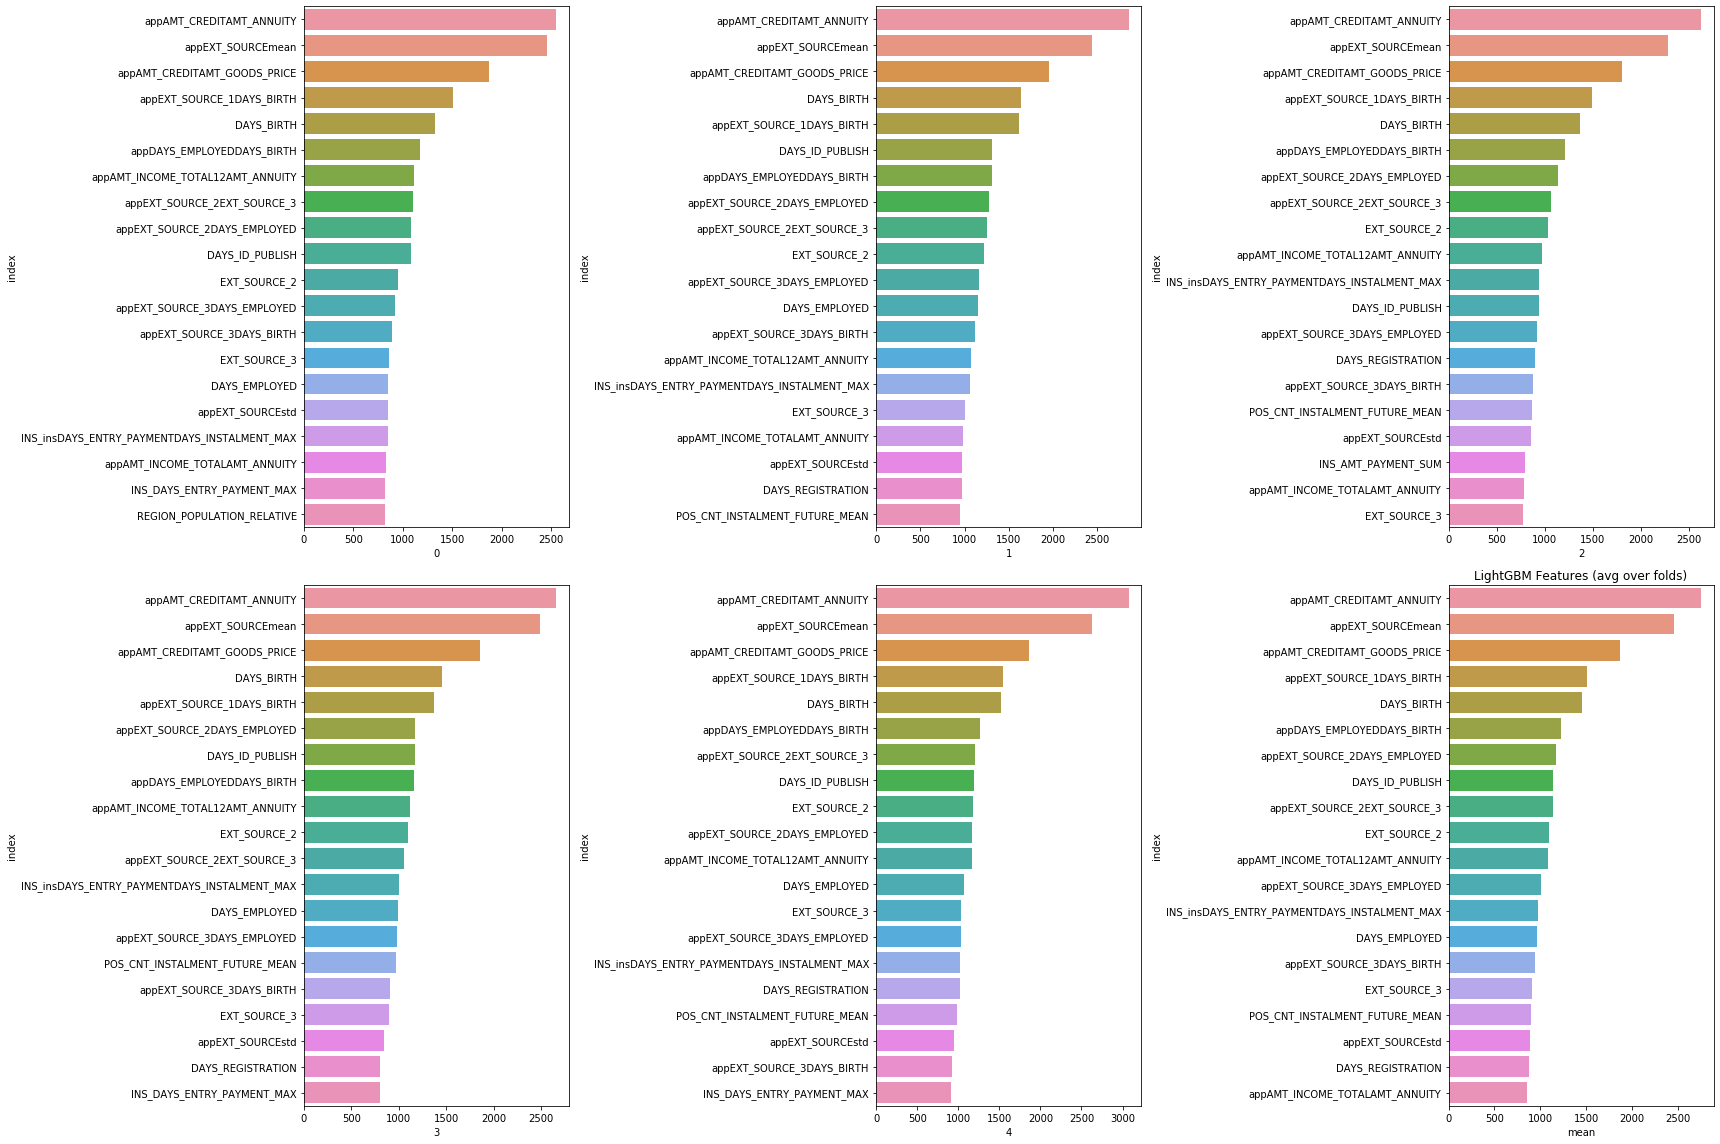

In [53]:
display_folds_importances(feature_importance)

In [54]:
feature_importance[feature_importance['mean'] == 0].shape

(66, 6)

In [76]:
feature_importance.sort_values('mean', ascending = False).head(20)

,0,1,2,3,4,mean
app AMT_CREDIT / AMT_ANNUITY,2550,2856,2628,2660,3073,2753.4
app EXT_SOURCE mean,2458,2443,2288,2494,2624,2461.4
app AMT_CREDIT / AMT_GOODS_PRICE,1875,1952,1806,1857,1865,1871.0
app EXT_SOURCE_1 / DAYS_BIRTH,1509,1616,1495,1376,1547,1508.6
DAYS_BIRTH,1322,1635,1365,1453,1515,1458.0
app DAYS_EMPLOYED / DAYS_BIRTH,1170,1307,1209,1159,1267,1222.4
app EXT_SOURCE_2 / DAYS_EMPLOYED,1082,1278,1138,1175,1172,1169.0
DAYS_ID_PUBLISH,1080,1308,938,1170,1190,1137.2
EXT_SOURCE_2 * EXT_SOURCE_3,1099,1254,1065,1056,1203,1135.4
EXT_SOURCE_2,954,1226,1038,1094,1178,1098.0


In [74]:
feature_importance.rename(index={ 
    'appAMT_CREDITAMT_ANNUITY': 'app AMT_CREDIT / AMT_ANNUITY',
    'appEXT_SOURCEmean':'app EXT_SOURCE mean', 
    'appAMT_CREDITAMT_GOODS_PRICE':'app AMT_CREDIT / AMT_GOODS_PRICE', 
    'appEXT_SOURCE_1DAYS_BIRTH':'app EXT_SOURCE_1 / DAYS_BIRTH',
    'appDAYS_EMPLOYEDDAYS_BIRTH':'app DAYS_EMPLOYED / DAYS_BIRTH',
    'appEXT_SOURCE_2DAYS_EMPLOYED':'app EXT_SOURCE_2 / DAYS_EMPLOYED',
    'appEXT_SOURCE_2EXT_SOURCE_3':'EXT_SOURCE_2 * EXT_SOURCE_3',
    'appAMT_INCOME_TOTAL12AMT_ANNUITY':'app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY',
    'appEXT_SOURCE_3DAYS_EMPLOYED':'app EXT_SOURCE_3 / DAYS_EMPLOYED',
    'INS_insDAYS_ENTRY_PAYMENTDAYS_INSTALMENT_MAX':'ins DAYS_ENTRY_PAYMENT - DAYS_INSTALLMENT MAX',
    'appEXT_SOURCE_3DAYS_BIRTH':'app EXT_SOURCE_3 / DAYS_BIRTH',
    'appAMT_INCOME_TOTALAMT_ANNUITY':'app AMT_INCOME_TOTAL / AMT_ANNUITY',
}, inplace=True)

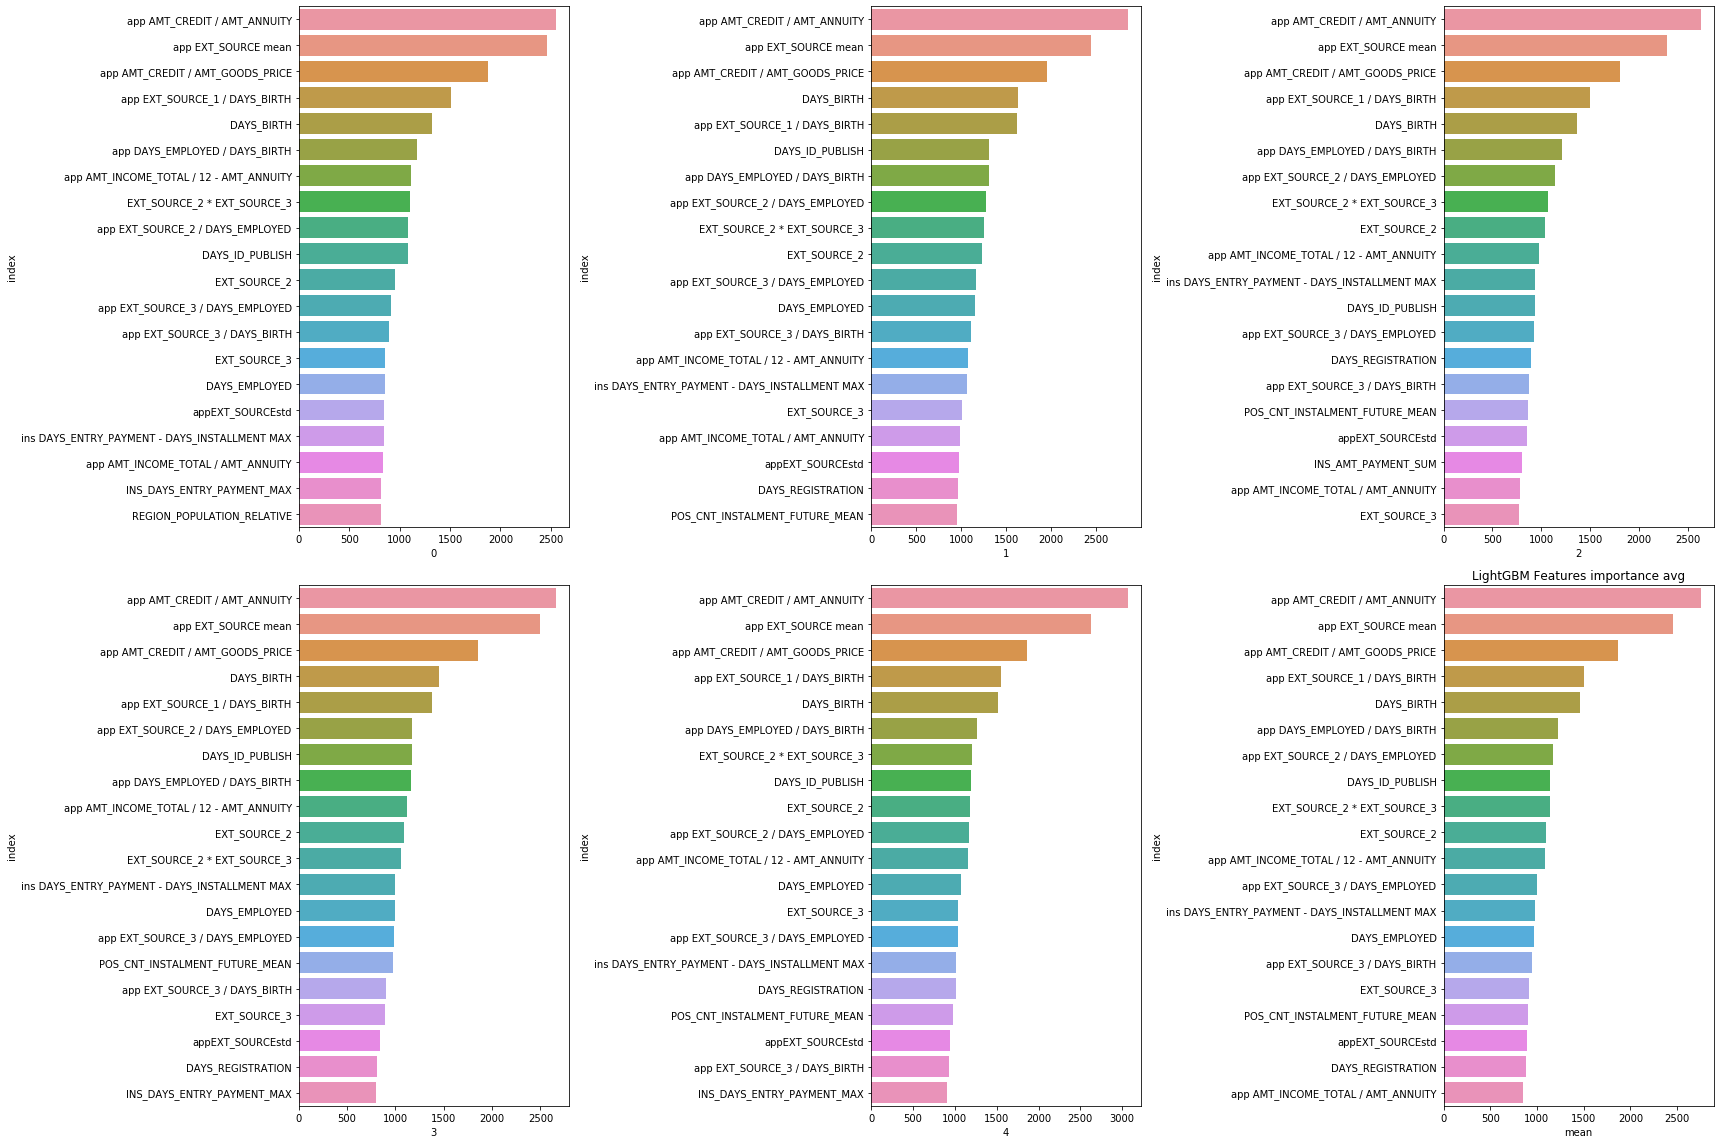

In [82]:
display_folds_importances(feature_importance)